In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd '/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_4/data_day_7'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_4/data_day_7


In [ ]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

%matplotlib inline

In [ ]:
sc = SparkContext(master="local", appName="New Spark Context")
spark = SparkSession(sc)

In [ ]:
df = spark.read.csv("data3D.csv", header=True, inferSchema=True)
df = df.select('x', 'y', 'z')
df.show(5)

+-----------------+------------------+------------------+
|                x|                 y|                 z|
+-----------------+------------------+------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|
|4.414367138680041|-10.32624175635328| 8.963324308916228|
|5.005396944639823|-9.301070062115645| 10.35473056351597|
|4.120163380083817|-7.602476887414266|11.899997733558848|
|-9.90345298323414| 6.018967450867092|2.0499450056095667|
+-----------------+------------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.pipeline import Pipeline

assembler = VectorAssembler(inputCols=['x', 'y', 'z'], outputCol='non_scale_features')
scaler = StandardScaler(inputCol='non_scale_features', outputCol='features')
pipeline_pre = Pipeline(stages=[assembler, scaler])
pipeline_pre_fitted = pipeline_pre.fit(df)
final_df = pipeline_pre_fitted.transform(df)
final_df.select('features').show(5, truncate=False)

+------------------------------------------------------------+
|features                                                    |
+------------------------------------------------------------+
|[1.0159673512169853,-0.8133579916042454,-1.1300631023636731]|
|[0.794112724705543,-1.321371532702522,1.3988923401033726]   |
|[0.900434712625481,-1.1901880174546264,1.616046989924009]   |
|[0.741187596138344,-0.9728318176240076,1.857214477910123]   |
|[-1.7815595725145974,0.770202018652675,0.31993178726421884] |
+------------------------------------------------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


k_means_result = []
for k in range(2, 11):
    # fit model
    k_means = KMeans(featuresCol='features', k=k, seed=42)
    model = k_means.fit(final_df)

    # compute wsse
    wsse = model.computeCost(final_df)

    # Compute silhouette
    predictions = model.transform(final_df)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)

    k_means_result.append((k, wsse, silhouette))
    print('With k = {}, Sum of Squared Error = {:.4f}, silhouette = {:.4f}'.format(k, wsse, silhouette))
k_means_result = pd.DataFrame(k_means_result, columns=['k', 'wsse', 'silhouette'])

With k = 2, Sum of Squared Error = 1155067.2563, silhouette = 0.7597
With k = 3, Sum of Squared Error = 297656.4092, silhouette = 0.9245
With k = 4, Sum of Squared Error = 146718.5045, silhouette = 0.9262
With k = 5, Sum of Squared Error = 72720.1851, silhouette = 0.8812
With k = 6, Sum of Squared Error = 68619.1385, silhouette = 0.7658
With k = 7, Sum of Squared Error = 64343.7400, silhouette = 0.6679
With k = 8, Sum of Squared Error = 60207.1381, silhouette = 0.5622
With k = 9, Sum of Squared Error = 58176.7718, silhouette = 0.5553
With k = 10, Sum of Squared Error = 56955.6186, silhouette = 0.5486


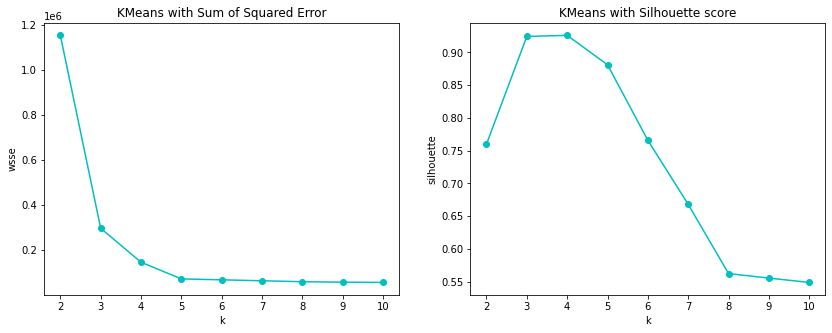

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(k_means_result['k'], k_means_result['wsse'], 'co-')
plt.xlabel('k')
plt.ylabel('wsse')
plt.title('KMeans with Sum of Squared Error')

plt.subplot(1,2,2)
plt.plot(k_means_result['k'], k_means_result['silhouette'], 'co-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('KMeans with Silhouette score')
plt.show()

In [ ]:
# Select k
k = 5
k_means = KMeans(featuresCol='features', k=k, seed=42)
model = k_means.fit(final_df)

# compute wsse
wsse = model.computeCost(final_df)

# Compute silhouette
predictions = model.transform(final_df)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print('With k = {}, Sum of Squared Error = {:.4f}, silhouette = {:.4f}'.format(k, wsse, silhouette))

# Compute the centers
centers = model.clusterCenters()
print('Cluster Centers: ')
for center in centers:
    print(center)

With k = 5, Sum of Squared Error = 72720.1851, silhouette = 0.8812
Cluster Centers: 
[ 0.74896823 -1.2269015   1.46702482]
[-1.59030525  0.93719373  0.31581855]
[ 0.35333304 -0.87989323 -1.07356038]
[-0.45182036  1.15367577  0.72369935]
[ 1.19780088 -0.73650198 -0.99421169]


In [ ]:
predictions.select('features', 'prediction').show(5, truncate=False)

+------------------------------------------------------------+----------+
|features                                                    |prediction|
+------------------------------------------------------------+----------+
|[1.0159673512169853,-0.8133579916042454,-1.1300631023636731]|4         |
|[0.794112724705543,-1.321371532702522,1.3988923401033726]   |0         |
|[0.900434712625481,-1.1901880174546264,1.616046989924009]   |0         |
|[0.741187596138344,-0.9728318176240076,1.857214477910123]   |0         |
|[-1.7815595725145974,0.770202018652675,0.31993178726421884] |1         |
+------------------------------------------------------------+----------+
only showing top 5 rows



In [ ]:
predictions.groupBy('prediction').count().sort('prediction').show()

+----------+------+
|prediction| count|
+----------+------+
|         0|200000|
|         1|199983|
|         2|200013|
|         3|200017|
|         4|199987|
+----------+------+



In [42]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
predictions = model.transform(final_df)

value_func = udf(lambda v: v.values.tolist(), ArrayType(DoubleType()))
predictions = predictions.withColumn("features", value_func("features"))
predictions = predictions.withColumn('x_scaled', col('features').getItem(0))
predictions = predictions.withColumn('y_scaled', col('features').getItem(1))
predictions = predictions.withColumn('z_scaled', col('features').getItem(2))

result = predictions.select('x_scaled', 'y_scaled', 'z_scaled', 'prediction').toPandas()
result

,x_scaled,y_scaled,z_scaled,prediction
0,1.015967,-0.813358,-1.130063,4
1,0.794113,-1.321372,1.398892,0
2,0.900435,-1.190188,1.616047,0
3,0.741188,-0.972832,1.857214,0
4,-1.781560,0.770202,0.319932,1
...,...,...,...,...
999995,1.040770,-1.150227,1.619526,0
999996,1.383050,-0.711970,-1.161897,4
999997,0.288521,-1.138478,-1.104821,2
999998,-1.421365,0.747392,0.301475,1


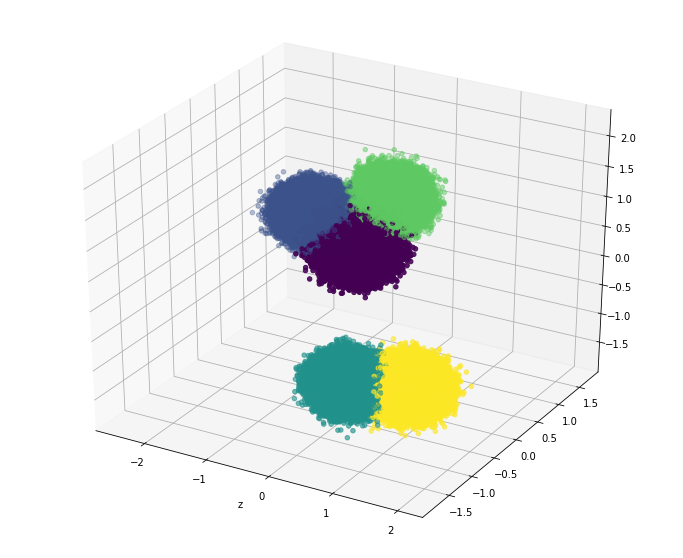

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10)).gca(projection='3d')
fig.scatter(result.x_scaled, result.y_scaled, result.z_scaled, c=result.prediction)
fig.set_xlabel('x')
fig.set_xlabel('y')
fig.set_xlabel('z')
plt.show()

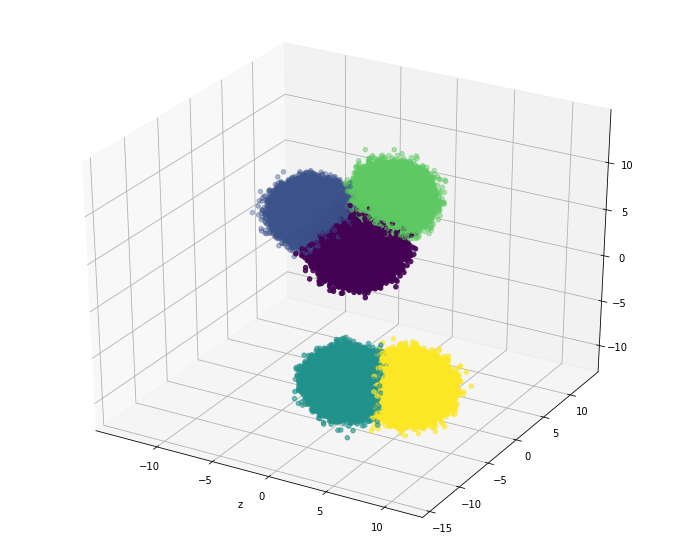

In [45]:
result_2 = predictions.select('x', 'y', 'z', 'prediction').toPandas()

fig = plt.figure(figsize=(12,10)).gca(projection='3d')
fig.scatter(result_2.x, result_2.y, result_2.z, c=result_2.prediction)
fig.set_xlabel('x')
fig.set_xlabel('y')
fig.set_xlabel('z')
plt.show()

In [1]:
# import pandas as pd
# recs=model.recommendForAllUsers(10).toPandas()
# nrecs=recs.recommendations.apply(pd.Series) \
#             .merge(recs, right_index = True, left_index = True) \
#             .drop(["recommendations"], axis = 1) \
#             .melt(id_vars = ['reviewerID_idx'], value_name = "recommendation") \
#             .drop("variable", axis = 1) \
#             .dropna() 
# nrecs=nrecs.sort_values('reviewerID_idx')
# nrecs=pd.concat([nrecs['recommendation'].apply(pd.Series), 
#                  nrecs['reviewerID_idx']], axis = 1)
# nrecs.columns = [        
#         'ProductID_index',
#         'Rating',
#         'UserID_index'       
#      ]


# md=data_indexed.select(['reviewerID', 'reviewerID_idx', 
#                         'asin', 'asin_idx'])
# md=md.toPandas()
# dict1 =dict(zip(md['reviewerID_idx'],md['reviewerID']))
# dict2=dict(zip(md['asin_idx'],md['asin']))
# nrecs['reviewerID']=nrecs['UserID_index'].map(dict1)
# nrecs['asin']=nrecs['ProductID_index'].map(dict2)
# nrecs=nrecs.sort_values('reviewerID')
# nrecs.reset_index(drop=True, inplace=True)
# new=nrecs[['reviewerID','asin','Rating']]
# new['recommendations'] = list(zip(new.asin, new.Rating))
# res=new[['reviewerID','recommendations']]  
# res_new=res['recommendations'].groupby([res.reviewerID])\
#                                 .apply(list).reset_index()